In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [30]:

# 1. 
qqq = yf.download('QQQ', start='2015-01-01', end='2025-01-01')
vix = yf.download('^VIX', start='2015-01-01', end='2025-01-01')

# 2. QQQ Return and Annualized Realized Volatility
qqq['Return'] = qqq['Close'].pct_change()
qqq['Realized_Volatility'] = qqq['Return'].rolling(window=21).std() * np.sqrt(252)
qqq.dropna(inplace=True)

# 3. VIX
vix = vix[['Close']].rename(columns={'Close': 'VIX'})
dataset = qqq.merge(vix, left_index=True, right_index=True)
dataset['Date'] = dataset.index
dataset1 = dataset[['Date', 'Return', 'Realized_Volatility', 'Volume', 'VIX']].copy()

# 4. RSI (14-day)
delta = qqq['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
dataset1['RSI_14'] = rsi

# reset index
dataset1.reset_index(drop=True, inplace=True)

# 5. VXN (Nasdaq Volatility Index)
vxn = yf.download('^VXN', start='2015-01-01', end='2025-01-01')
vxn = vxn[['Close']].rename(columns={'Close': 'VXN'})
dataset1 = dataset1.merge(vxn, left_on='Date', right_index=True, how='left')

# 6. Fed Funds Rate (proxy: ^IRX)
fed = yf.download('^IRX', start='2015-01-01', end='2025-01-01')
fed = fed[['Close']].rename(columns={'Close': 'FedRate'})
dataset1 = dataset1.merge(fed, left_on='Date', right_index=True, how='left')

# 7. 
dataset1.dropna(inplace=True)
dataset1.reset_index(drop=True, inplace=True)

print(dataset1.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Date    Return Realized_Volatility    Volume    VIX     RSI_14  \
Ticker                                                QQQ   ^VIX              
0      2015-02-24  0.000737            0.141939  19745000  13.69  86.434336   
1      2015-02-25 -0.002486            0.142385  19472300  13.84  84.469767   
2      2015-02-26  0.005077            0.100264  22255500  13.91  83.773201   
3      2015-02-27 -0.004409            0.099524  27757600  13.34  85.464183   
4      2015-03-02  0.009041            0.099096  22988600  13.04  90.717852   

Price     VXN FedRate  
Ticker   ^VXN    ^IRX  
0       14.26   0.018  
1       14.38   0.015  
2       14.33   0.013  
3       14.62   0.008  
4       14.27   0.005  


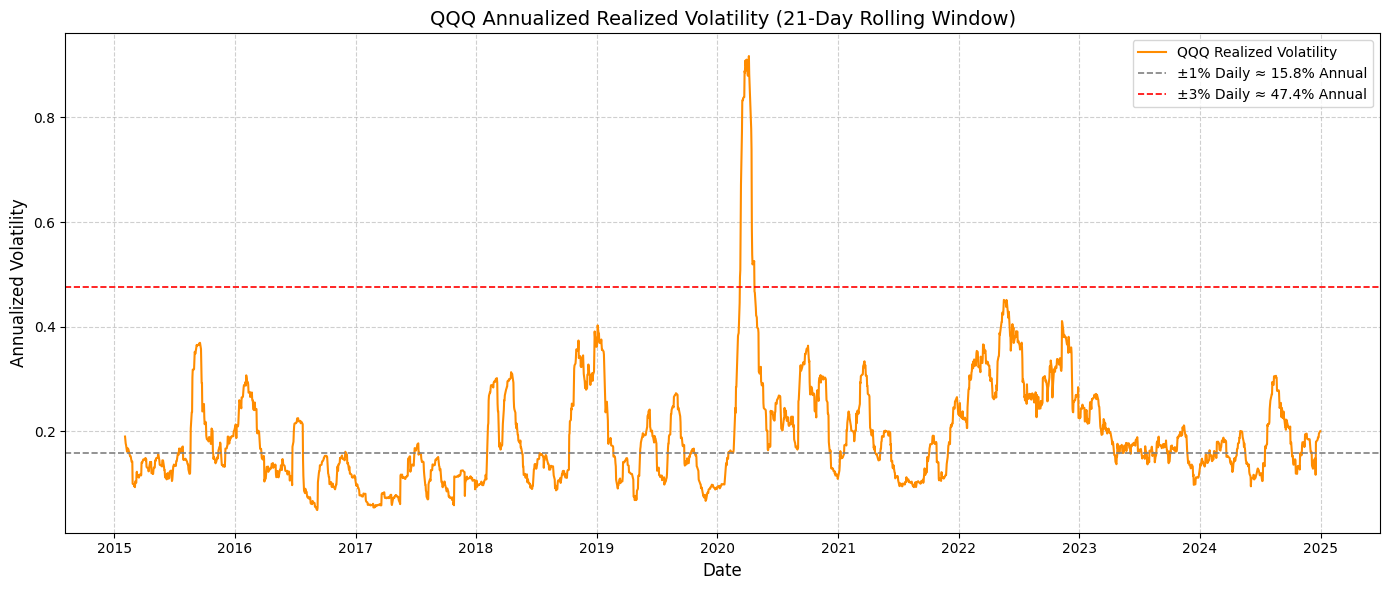

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(qqq.index, qqq['Realized_Volatility'], label='QQQ Realized Volatility', color='darkorange', linewidth=1.5)

plt.axhline(np.sqrt(252)*0.01, linestyle='--', color='gray', linewidth=1.2, label='±1% Daily ≈ 15.8% Annual')
plt.axhline(np.sqrt(252)*0.03, linestyle='--', color='red', linewidth=1.2, label='±3% Daily ≈ 47.4% Annual')

plt.title('QQQ Annualized Realized Volatility (21-Day Rolling Window)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annualized Volatility', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [32]:
correlation = dataset1[['Realized_Volatility', 'VIX']].corr()
print(correlation)


Price                      Realized_Volatility       VIX
Ticker                                              ^VIX
Price               Ticker                              
Realized_Volatility                   1.000000  0.806945
VIX                 ^VIX              0.806945  1.000000


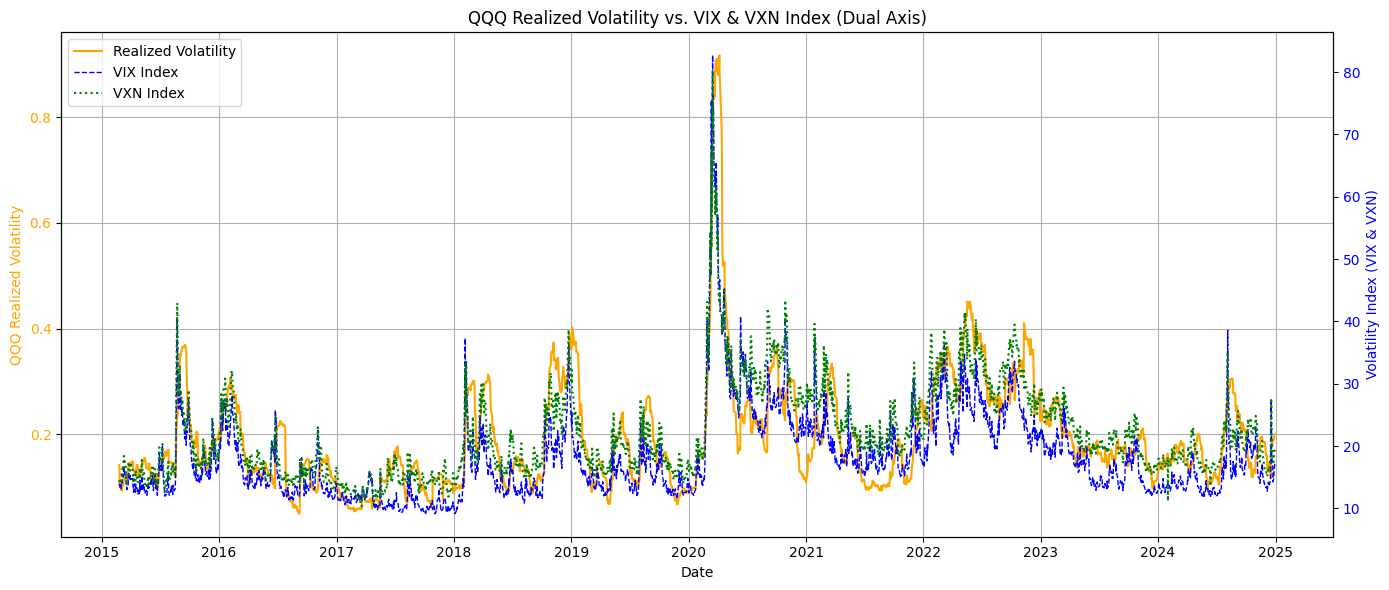

In [33]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# left: Realized Volatility
ax1.set_xlabel('Date')
ax1.set_ylabel('QQQ Realized Volatility', color='orange')
ax1.plot(dataset1['Date'], dataset1['Realized_Volatility'], color='orange', label='Realized Volatility')
ax1.tick_params(axis='y', labelcolor='orange')

# right: VIX 和 VXN
ax2 = ax1.twinx()
ax2.set_ylabel('Volatility Index (VIX & VXN)', color='blue')
ax2.plot(dataset1['Date'], dataset1['VIX'], color='blue', linestyle='--', label='VIX Index', linewidth = 1)
ax2.plot(dataset1['Date'], dataset1['VXN'], color='green', linestyle=':', label='VXN Index')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('QQQ Realized Volatility vs. VIX & VXN Index (Dual Axis)')
fig.tight_layout()
ax1.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


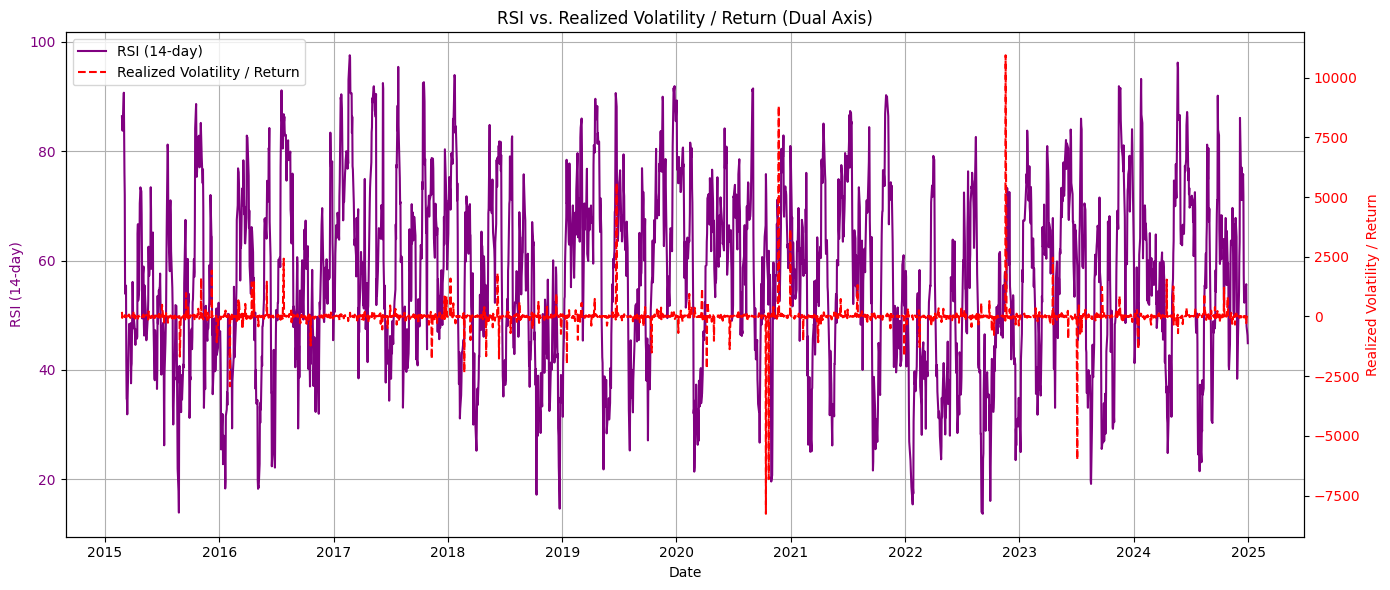

In [34]:
fig, ax1 = plt.subplots(figsize=(14, 6))

#left: RSI
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI (14-day)', color='purple')
ax1.plot(dataset1['Date'], dataset1['RSI_14'], color='purple', label='RSI (14-day)')
ax1.tick_params(axis='y', labelcolor='purple')

# Right: Realized Volatility / Return
ax2 = ax1.twinx()
ax2.set_ylabel('Realized Volatility / Return', color='red')
ax2.plot(dataset1['Date'], dataset1['Realized_Volatility'] / dataset1['Return'], 
         color='red', linestyle='--', label='Realized Volatility / Return')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('RSI vs. Realized Volatility / Return (Dual Axis)')
fig.tight_layout()
ax1.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


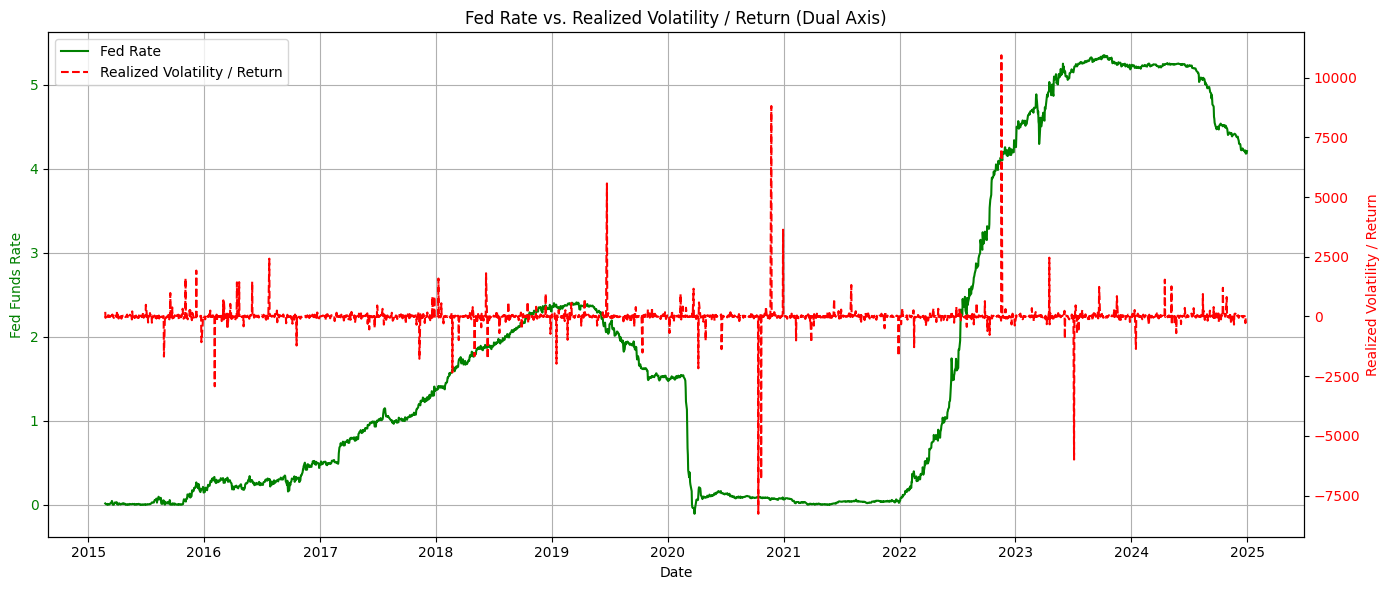

In [35]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# left:  Fed Funds Rate
ax1.set_xlabel('Date')
ax1.set_ylabel('Fed Funds Rate', color='green')
ax1.plot(dataset1['Date'], dataset1['FedRate'], color='green', label='Fed Rate')
ax1.tick_params(axis='y', labelcolor='green')

# Right: Realized Volatility / Return
ax2 = ax1.twinx()
ax2.set_ylabel('Realized Volatility / Return', color='red')
ax2.plot(dataset1['Date'], dataset1['Realized_Volatility'] / dataset1['Return'], 
         color='red', linestyle='--', label='Realized Volatility / Return')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Fed Rate vs. Realized Volatility / Return (Dual Axis)')
fig.tight_layout()
ax1.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


Option data

In [36]:
# import wrds

# conn = wrds.Connection()

# df = conn.raw_sql("""
#     SELECT date, exdate, cp_flag, strike_price, 
#            impl_volatility, delta, gamma, 
#            best_bid, best_offer, volume, open_interest, 
#            underlying_bid, underlying_ask
#     FROM optionm.opprcd
#     WHERE secid = 108105
#       AND date BETWEEN '2023-01-01' AND '2025-12-31'
#       AND impl_volatility IS NOT NULL
#       AND best_bid IS NOT NULL AND best_offer IS NOT NULL
#       AND volume > 0
#       AND open_interest > 0
# """)

# df['date'] = pd.to_datetime(df['date'])
# df['exdate'] = pd.to_datetime(df['exdate'])
# df['DTE'] = (df['exdate'] - df['date']).dt.days
# df['strike_price'] = df['strike_price'] / 100

# #Filter reasonable DTE (e.g. 25~45 days, for hedging)
# df_filtered = df[(df['DTE'] >= 25) & (df['DTE'] <= 45)]


# df_filtered['spot_price'] = (df_filtered['underlying_bid'] + df_filtered['underlying_ask']) / 2
# df_filtered['moneyness'] = abs(df_filtered['spot_price'] / df_filtered['strike_price'] - 1)


# atm_options = (
#     df_filtered.sort_values(['date', 'cp_flag', 'moneyness'])
#                .groupby(['date', 'cp_flag'])
#                .first()
#                .reset_index()
# )

# call_df = atm_options[atm_options['cp_flag'] == 'C'].copy()
# put_df = atm_options[atm_options['cp_flag'] == 'P'].copy()

# call_df = call_df.add_prefix('call_')
# put_df = put_df.add_prefix('put_')

In [37]:
# dataset_option = pd.merge(
#     call_df,
#     put_df,
#     left_on='call_date',
#     right_on='put_date',
#     suffixes=('_call', '_put')
# )

# dataset_option['date'] = dataset_option['call_date']
# dataset_option.drop(columns=['put_date'], inplace=True)

# dataset_option.sort_values(by='date', inplace=True)
# dataset_option.reset_index(drop=True, inplace=True)


Modeling Prepare

In [38]:

risk_modling_data=dataset1.copy()
risk_modling_data['Date'] = pd.to_datetime(risk_modling_data['Date'])

train_set = risk_modling_data[(risk_modling_data['Date'] >= '2015-01-01') & (risk_modling_data['Date'] < '2017-12-31')]
val_set   = risk_modling_data[(risk_modling_data['Date'] >= '2017-12-31') & (risk_modling_data['Date'] < '2020-12-31')]
test_set  = risk_modling_data[(risk_modling_data['Date'] >= '2020-12-31') & (risk_modling_data['Date'] < '2023-12-31')]

print(f"Training: {len(train_set)} rows")
print(f"Validation: {len(val_set)} rows")
print(f"Test: {len(test_set)} rows")


Training: 719 rows
Validation: 755 rows
Test: 754 rows


In [39]:
dataset1

Price,Date,Return,Realized_Volatility,Volume,VIX,RSI_14,VXN,FedRate
Ticker,,,,QQQ,^VIX,,^VXN,^IRX
0,2015-02-24,0.000737,0.141939,19745000,13.69,86.434336,14.260000,0.018
1,2015-02-25,-0.002486,0.142385,19472300,13.84,84.469767,14.380000,0.015
2,2015-02-26,0.005077,0.100264,22255500,13.91,83.773201,14.330000,0.013
3,2015-02-27,-0.004409,0.099524,27757600,13.34,85.464183,14.620000,0.008
4,2015-03-02,0.009041,0.099096,22988600,13.04,90.717852,14.270000,0.005
...,...,...,...,...,...,...,...,...
2474,2024-12-24,0.013560,0.188410,17558200,14.27,54.902090,17.030001,4.200
2475,2024-12-26,-0.000679,0.188692,19090500,14.73,55.689407,17.530001,4.215
2476,2024-12-27,-0.013293,0.195762,33839600,15.95,48.036038,18.540001,4.178


In [40]:
dataset1.columns = [
    'Date',
    'QQQ_Return',
    'QQQ_Realized_Volatility',
    'QQQ_Volume',
    'VIX',
    'RSI_14',
    'VXN',
    'FedRate'
]


In [41]:
dataset1

,Date,QQQ_Return,QQQ_Realized_Volatility,QQQ_Volume,VIX,RSI_14,VXN,FedRate
0,2015-02-24,0.000737,0.141939,19745000,13.69,86.434336,14.260000,0.018
1,2015-02-25,-0.002486,0.142385,19472300,13.84,84.469767,14.380000,0.015
2,2015-02-26,0.005077,0.100264,22255500,13.91,83.773201,14.330000,0.013
3,2015-02-27,-0.004409,0.099524,27757600,13.34,85.464183,14.620000,0.008
4,2015-03-02,0.009041,0.099096,22988600,13.04,90.717852,14.270000,0.005
...,...,...,...,...,...,...,...,...
2474,2024-12-24,0.013560,0.188410,17558200,14.27,54.902090,17.030001,4.200
2475,2024-12-26,-0.000679,0.188692,19090500,14.73,55.689407,17.530001,4.215
2476,2024-12-27,-0.013293,0.195762,33839600,15.95,48.036038,18.540001,4.178
2477,2024-12-30,-0.013300,0.199852,34584000,17.40,46.343574,19.790001,4.182


In [42]:
dataset1.to_csv("QQQ_MarketRisk.csv", index=False)
